<a href="https://colab.research.google.com/github/WesleyAldridge/HW1_MachineLearning/blob/master/HW1_MachineLearning_Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem 1:

Use logistic regression with mean squared error loss.

Instructions for problems 1 and 2:

- Load the training and test data using Keras, no validation set needed.
- Train 10 classifiers that perform binary classification: Is the input image the digit i or is it a digit different from i? Each of the ten classifiers has an input layer consisting of 28 x 28 input neurons and an output layer consisting of a single output neuron.
- Implement mini-batch stochastic gradient descent using only numpy, that is, you are not allowed to use TensorFlow/Keras for SGD.
- Use argmax to determine the classifier with the strongest output and declare the corresponding digit as output.

In [0]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [0]:
def sigmoid_double(x):
    # Simple implementation of the sigmoid function for double values.
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_prime_double(x):
    # Simple implementation of the derivative of of the sigmoid function for double values.
    return sigmoid_double(x) * (1 - sigmoid_double(x))


def sigmoid(z):
    # Simple implementation of the sigmoid function for vectors.
    return np.vectorize(sigmoid_double)(z)


def sigmoid_prime(z):
    # Simple implementation of the derivative of the sigmoid function for vectors.
    return np.vectorize(sigmoid_prime_double)(z)


class Layer:
    # Layers are stacked to build a sequential neural network.
    def __init__(self):
        self.params = []

        # A layer know its predecessor (previous layer)
        self.previous = None
        # and its successor (next layer).
        self.next = None

        # Each layer can persist data flowing into and out of it
        # in the forward pass.
        self.input_data = None
        self.output_data = None

        # Analogously, a layer holds input and output data
        # for the backward pass.
        self.input_delta = None
        self.output_delta = None

    def connect(self, layer):
        # This method connects a layer to its direct neighbors
        # in the sequential network.
        self.previous = layer
        layer.next = self

    def forward(self):
        # Each layer implementation has to provide a function
        # to feed input data forward.
        raise NotImplementedError

    def get_forward_input(self):
        # input_data is reserved for the first layer;
        # all others get their inputs from the predecessors.
        if self.previous is not None:
            return self.previous.output_data
        else:
            return self.input_data

    def backward(self):
        # Layers have to implement backpropagation of error terms -
        # a way to feed input errors backward through the network.
        raise NotImplemented

    def get_backward_input(self):
        # input_delta is reserved for the last layer;
        # all other layers get their error terms from their successors.
        if self.next is not None:
            return self.next.output_delta
        else:
            return self.input_delta

    def clear_deltas(self):
        # You compute and accumulate deltas per mini-batch,
        # after which you need to reset these deltas.
        pass

    def update_params(self, learning_rate):
        # Update layer parameters according to current deltas,
        # using the specified learning_rate.
        pass

    def describe(self):
        # Layer implementation can print their properties.
        raise NotImplemented


class ActivationLayer(Layer):
    # This activation layer uses the sigmoid function
    # to activate neurons.
    def __init__(self, input_dim):
        super(ActivationLayer, self).__init__()

        self.input_dim = input_dim
        self.output_dim = input_dim

    def forward(self):
        # The forward pass is simply applying
        # the sigmoid function to the input_data.
        data = self.get_forward_input()
        self.output_data = sigmoid(data)
        #print("activation layer")
        #print("  data:", data.shape)
        #print("  output_data:", self.output_data.shape)

    def backward(self):
        # The backward pass is element-wise multiplication of
        # the error term with the sigmoid derivative evaluated at
        # the input to this layer.
        delta = self.get_backward_input()
        data = self.get_forward_input()
        self.output_delta = delta * sigmoid_prime(data)

    def describe(self):
        print("|-- " + self.__class__.__name__)
        print("  |-- dimensions: ({} {})".format(self.input_dim, self.output_dim))


class DenseLayer(Layer):
    # Dense layers have input and output dimensions.
    def __init__(self,  input_dim, output_dim):

        super(DenseLayer, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        # Randomly initialize weight matrix and bias vector.
        self.weight = np.random.randn(output_dim, input_dim)
        self.bias = np.random.randn(output_dim, 1)

        # The layer parameters consist of weights and bias terms.
        self.params = [self.weight, self.bias]

        # Deltas for weights and biases are set to 0.
        self.delta_w = np.zeros(self.weight.shape)
        self.delta_b = np.zeros(self.bias.shape)

    def forward(self):
        # The forward pass of the dense layer is
        # the affine-linear transformation on the input data
        # described by weights and biases.
        data = self.get_forward_input()
        self.output_data = np.dot(self.weight, data) + self.bias
        #print("dense layer")
        #print("  data:", data.shape)
        #print("  weight:", self.weight.shape)
        #print("  bias:", self.bias.shape)
        #print("  output_data:", self.output_data.shape)

    def backward(self):
        # For the backward pass, you first get input data and delta.
        data = self.get_forward_input()
        delta = self.get_backward_input()

        # The current delta is added to the bias delta.
        self.delta_b += delta

        # Then you add this term to the weight delta.
        self.delta_w += np.dot(delta, data.transpose())

        # The backward pass is completed by passing
        # an output delta to the previous layer.
        self.output_delta = np.dot(self.weight.transpose(), delta)

    def update_params(self, rate):
        # Using weight and bias deltas,
        # you can update model parameters
        # with gradient descent.
        self.weight -= rate * self.delta_w
        self.bias -= rate * self.delta_b

    def clear_deltas(self):
        # After updating parameters,
        # you should reset all deltas.
        self.delta_w = np.zeros(self.delta_w.shape)
        self.delta_b = np.zeros(self.delta_b.shape)

    def describe(self):
        print("|--- " + self.__class__.__name__)
        print("  |-- dimensions: ({}, {})".format(self.input_dim, self.output_dim))


class MSE:
    # Mean squared error loss function
    def __init__(self):
        pass

    @staticmethod
    def loss_function(predictions, labels):
        diff = predictions - labels
        # By defining MSE as 0.5 times
        # the square difference between
        # predictions and labels ...
        return 0.5 * sum(diff * diff)

    @staticmethod
    def loss_derivative(predictions, labels):
        # ... the loss derivative is simply
        # the difference between predictions and labels
        #print("predictions:", predictions)
        #print("labels:", labels)
        return predictions - labels


class SequentialNetwork:
    # In a sequential neural network, you stack layers sequentially.
    def __init__(self, loss=None):
        print("Initialize Network...")
        self.layers = []
        # If no loss is provided, MSE is used.
        if loss is None:
            self.loss = MSE()

    def add(self, layer):
        # Whenever you add a layer, you connect it
        # to its predecessor and let it describe itself.
        self.layers.append(layer)
        layer.describe()
        if len(self.layers) > 1:
            self.layers[-1].connect(self.layers[-2])

    def train(self, training_data, epochs, mini_batch_size, learning_rate, test_data=None):
        n = len(training_data)
        # To train you network, you pass over the data
        # for as many times as there are epochs.
        for epoch in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size] for
                k in range(0, n, mini_batch_size)
            ]
            # For each mini batch, you train your network.
            for mini_batch in mini_batches:
                self.train_batch(mini_batch, learning_rate)
            if test_data:
                # If you provided test data,
                # you evaluate your network on it after each epoch.
                n_test = len(test_data)
                print("Epoch {0}: {1} / {2}".format(epoch, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(epoch))

    def train_batch(self, mini_batch, learning_rate):
        # To train the network you,
        # compute feed-forward and backward pass...
        self.forward_backward(mini_batch)
        # ... and then update model parameters accordingly.
        self.update(mini_batch, learning_rate)

    def update(self, mini_batch, learning_rate):
        # A common technique is to normalize
        # the learning rate by the mini-batch size.
        learning_rate = learning_rate / len(mini_batch)

        # Update all layers
        for layer in self.layers:
            layer.update_params(learning_rate)
        # Clear all deltas in each layer.
        for layer in self.layers:
            layer.clear_deltas()

    def forward_backward(self, mini_batch):
        for x, y in mini_batch:
            self.layers[0].input_data = x
            # For each sample in the mini batch,
            # feed the features forward layer by layer.
            for layer in self.layers:
                layer.forward()
            # Compute the loss derivative for the output data.
            self.layers[-1].input_delta = \
                self.loss.loss_derivative(self.layers[-1].output_data, y)
            # Do layer-by-layer backpropagation of error terms.
            for layer in reversed(self.layers):
                layer.backward()

    def single_forward(self, x):
        # Pass a single sample forward and
        # return result.
        self.layers[0].input_data = x
        for layer in self.layers:
            layer.forward()
        return self.layers[-1].output_data

    def evaluate(self, test_data):
        # Compute accuracy on test data.
        test_results = [(
            np.argmax(self.single_forward(x)),
            np.argmax(y)
        ) for (x,y) in test_data]
        return sum(int(x == y) for (x,y) in test_results)

#Part 1:
##Load the training and test data using Keras, no validation set needed

(60000, 28, 28)
(60000,)
0


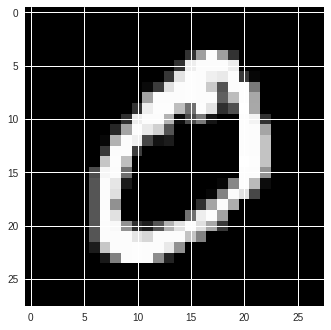

In [59]:
# load train and test data
(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

print(train_images_original.shape)
print(train_labels_original.shape)
example_index = 1
plt.figure()
_ = plt.imshow(np.reshape(train_images_original[example_index, :], (28,28)), 'gray')
print(train_labels_original[1])

(10000, 28, 28)
(10000,)
2


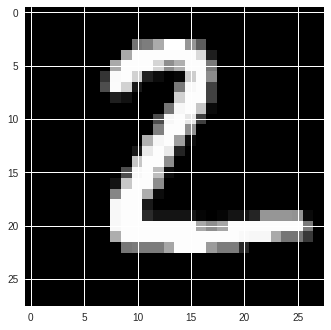

In [58]:
print(test_images_original.shape)
print(test_labels_original.shape)

example_index = 1
plt.figure()
_ = plt.imshow(np.reshape(test_images_original[example_index, :], (28,28)), 'gray')
print(test_labels_original[1])

#Part 2: 
##Train 10 classifiers that perform binary classification: Is the input image the digit i or is it a digit different from i? Each of the ten classifiers has an input layer consisting of 28 x 28 input neurons and an output layer consisting of a single output neuron.

In [53]:
# preprocess data

# 60,000 images (?)
# 28 * 28 = 784 input neurons per classifier
# 1 output neuron per classifier

train_images = train_images_original.reshape((60000, 28 * 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28 * 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels_original)
train_labels = train_labels.reshape((60000, 10, 1))

test_labels = to_categorical(test_labels_original)
test_labels = test_labels.reshape(10000, 10, 1)

train_data = [(train_images[i], train_labels[i]) for i in range(0, 60000)]
test_data = [(test_images[i], test_labels[i]) for i in range(0, 10000)]

print(train_images.shape)
print(train_labels_original)
print(test_labels_original)
print(train_labels[0])

(60000, 784, 1)
[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [0]:


#print(train_images.shape)
#print(train_labels.shape)

#print(test_images.shape)
#print(test_labels.shape)

net = SequentialNetwork()
net.add(DenseLayer(784, 100))
net.add(ActivationLayer(100))
net.add(DenseLayer(100, 10))
net.add(ActivationLayer(10))

#net.add(DenseLayer(392, 196))
#net.add(ActivationLayer(196))
#net.add(DenseLayer(196, 10))
#net.add(ActivationLayer(10))

net.train(train_data,
          epochs=10,
          mini_batch_size=10,
          learning_rate=3.0,
          test_data=test_data)

#print(net.single_forward(test_data[0][0]))

11493376/11490434 [==============================] - 1s 0us/step
Initialize Network...
|--- DenseLayer
  |-- dimensions: (784, 100)
|-- ActivationLayer
  |-- dimensions: (100 100)
|--- DenseLayer
  |-- dimensions: (100, 10)
|-- ActivationLayer
  |-- dimensions: (10 10)
Epoch 0: 4959 / 10000
Epoch 1: 6823 / 10000
Epoch 2: 6866 / 10000
Epoch 3: 6894 / 10000
Epoch 4: 6925 / 10000
Epoch 5: 6979 / 10000
Epoch 6: 7000 / 10000
Epoch 7: 6994 / 10000
Epoch 8: 7061 / 10000
Epoch 9: 7763 / 10000
